# Technical task 1 - Alex Gill

## Problem:

"You are required to calculate the operational risk capital provision for a fictional scenario that will form part of an ICAAP submission. The requirement for the bank is to quantify the bank’s expected financial losses due to operational risk at a 1 in 1000 year (99.9%) confidence level.  

For the purposes of this exercise, only one operational risk scenario will be considered and quantified. 

The bank has identified that a plausible ‘system downtime’ scenario in which customers lose access to all digital services for a period of time. The bank perceives that in the event of such an outage, the bank may suffer some reputational damage and revenue losses due to the outage.

Attached you will find a csv containing low, medium, high and extreme scenario estimates for the severity and frequency of such an event occurring. 

Using a Monte Carlo simulation, or any other method of your choosing, produce an estimate for the capital provision that the bank should hold for this scenario. Feel free to make any necessary assumptions in order to produce a numerical answer to the problem."

## Solution:

### Intro and initial assumptions

My basic approach will be to use the scenario estimates to fit each variable to an appropriate distribution, using some (limited!) domain knowledge. I will then define any expected correlations as new assumptions and sample from the resulting joint distribution to generate a distribution of outcomes. 

A simpler alternative would be to sample directly from the scenario probability tables, but this is an over-simplification of the problem. For example there is no reason to believe that there are only 4 possible outcomes for each variable, and that downtime would be capped 120 minutes etc. We will try this simple method first and use it as a benchmark / sense check on the main method.

Before we get started, there are some assumptions we need to make about the definitions of the scenarios themselves.

**Assumptions about the definitions of our scenarios**
* "Downtime" is the scenario for the total amount of system downtime during the year. This could be a single downtime incident or the sum of multiple incidents occuring over the year.
* "Revenue per minute" is the distribution of revenue earned per minute
* "Active clients" is the distribution of the number of clients using digital services during a system downtime event over the year. This will be positively correlated with the number of downtime minutes - the longer the downtime, the more customers are likely to be affected.
* "Attrition" is the likelihood of "active clients" leaving the bank as a result of the system downtime. Again, we expect this to be positively correlated with downtime minutes - the worse the system downtime, the more dissatisfied customers are likely to be.
* "Revenue per client" - I am not sure exactly how the risk capital provision works - i.e. whether it is calculated on all expected future lost revenues or just revenues during the relevant year - so for simplicity in this model, I will assume that this is the distribution of revenue relevant for the capital provision!  

Further assumptions will be defined later on as we build out the model. A model is just a set of assumptions about data - and all those assumptions should be defined!

### Set up and imports

In [1]:
# install relevant packages, if you need to!
!pip install scipy numpy matplotlib seaborn

In [2]:
# imports
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
# for reproducibility
seed = 47

In [4]:
# encode the scenario estimates in a dictionary
scenarios = {
    "downtime_minutes":{
        "value": [5, 30, 80, 120],
        "probability": [0.25, 0.5, 0.24, 0.01]
    },
    "revenue_per_minute":{
        "value": [100, 600, 1000, 3000],
        "probability": [0.25, 0.5, 0.24, 0.01]
    },
    "active_clients":{
        "value": [1000, 1400, 1900, 5000],
        "probability": [0.25, 0.5, 0.24, 0.01]
    },
    "attrition":{
        "value": [0.00, 0.02, 0.04, 0.07],
        "probability": [0.25, 0.5, 0.24, 0.01]
    },
    "revenue_per_client":{
        "value": [300, 700, 1300, 2500],
        "probability": [0.25, 0.5, 0.24, 0.01]
    },
}

## A) Simple approach

Let's start "simple" and use this results as a benchmark.

**Sample from the scenario tables directly and assume all variables are independent**

In [5]:
# try a simple approach
n_samples = 100_000
np.random.seed(seed)

losses_simple = []
direct_losses_simple = []
indirect_losses_simple = []

for n in tqdm(range(n_samples)): 
    downtime = np.random.choice(scenarios["downtime_minutes"]["value"], 1, p=scenarios["downtime_minutes"]["probability"])
    revenue_per_minute = np.random.choice(scenarios["revenue_per_minute"]["value"], 1, p=scenarios["revenue_per_minute"]["probability"])
    active_clients = np.random.choice(scenarios["active_clients"]["value"], 1, p=scenarios["active_clients"]["probability"])
    attrition = np.random.choice(scenarios["attrition"]["value"], 1, p=scenarios["attrition"]["probability"])
    revenue_per_client = np.random.choice(scenarios["revenue_per_client"]["value"], 1, p=scenarios["revenue_per_client"]["probability"])
    direct_loss_simple = downtime * revenue_per_minute 
    indirect_loss_simple = active_clients * attrition * revenue_per_client
    loss_simple = direct_loss_simple + indirect_loss_simple
    losses_simple.append(loss_simple[0])
    direct_losses_simple.append(direct_loss_simple[0])
    indirect_losses_simple.append(indirect_loss_simple[0])

100%|██████████| 100000/100000 [00:12<00:00, 7959.60it/s]


Text(0.5, 1.0, 'Sampling from the scenarios directly, 99.9% loss: 276400.0')

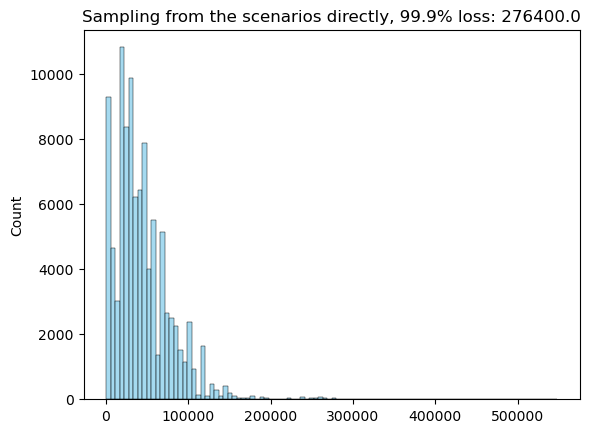

In [6]:
ax = sns.histplot(losses_simple,
                  bins=100,
                  color='skyblue')
ax.set_title(f"Sampling from the scenarios directly, 99.9% loss: {round(np.percentile(losses_simple, 99.9),0)}")

The "lumpiness" of this result illustrates how it is inappropriate. There are a finite number of values for the loss under this scenario method, whereas in reality the loss could take any positive value. Still, this is a helpful benchmark value. 

## B) More realistic approach

**Use the scenario tables as a guide to fit distributions to each variable, and factor in correlations where relevant**

### Fit the scenario tables to appropriate distributions

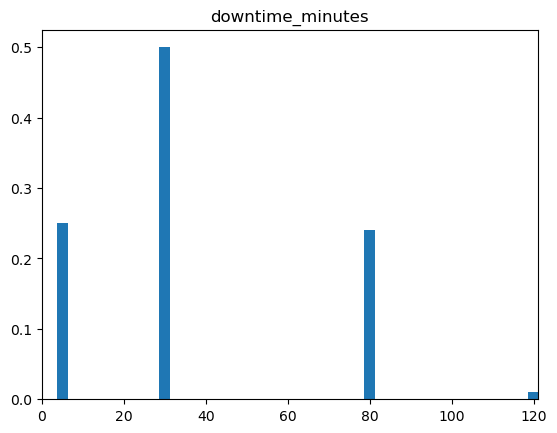

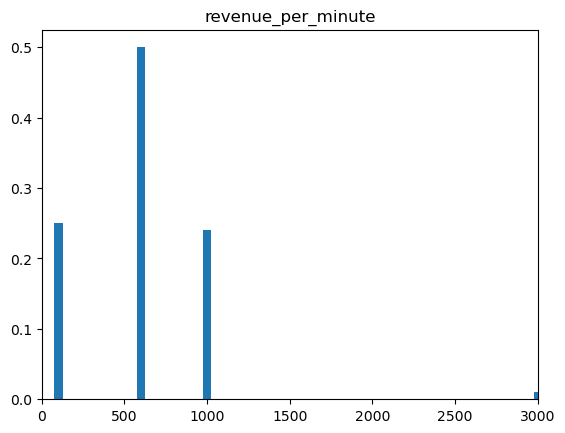

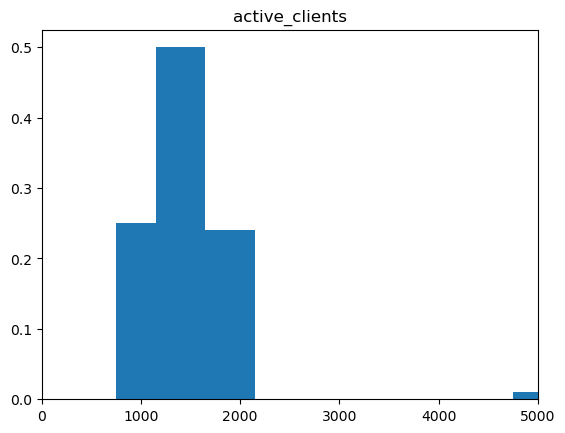

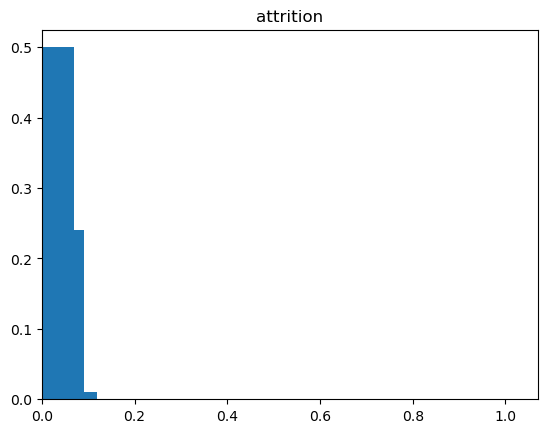

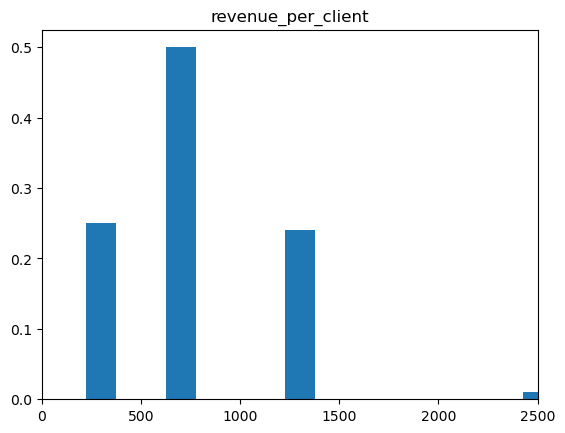

In [7]:
# plot the scenario tables
for scenario in scenarios:
    x = scenarios[scenario]["value"]
    y = scenarios[scenario]["probability"]
    plt.figure()
    plt.bar(x, y, width=min(x)/2+0.1) # hack to get the bar widths looking reasonable!
    plt.xlim(0, max(x)+1)
    plt.title(scenario)

**Assumptions about distributions**
* Attrition should follow a Beta distribution - it is fixed between 0 and 1 
* All other variables will be assumed to follow a lognormal distribution - they are all positive variables, with potentially long tails - and inspection of the graphs confirms that lognormal seems broadly appropriate. Revenue and some time variables are frequently modelled using the lognormal distribution so we should expect a reasonable fit. Active clients is technically discrete, but a quick check of a Poisson distribution shows it looks like a bad fit for the scenarios - we will approximate it as a lognormal and do not expect it to materially impact the results.

To fit each lognormal distribution, we will sample from the scenario table, fit the log of the sample data to a normal distribution and then re-parameterise it as a lognormal.

But first, let's look at attrition, which we assume to follow a Beta.

#### Fitting the beta - attrition

In [8]:
# fit the beta
n_samples = 10000
dist = scenarios["attrition"]
data = np.random.choice(dist["value"], n_samples, p=dist["probability"])
a, b, loc, scale = scipy.stats.beta.fit(data)

(0.0, 1.0)

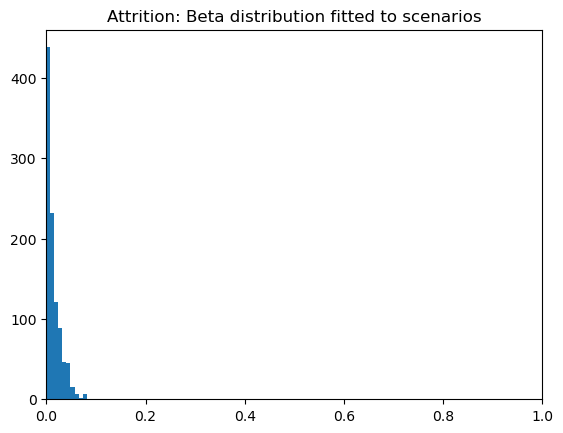

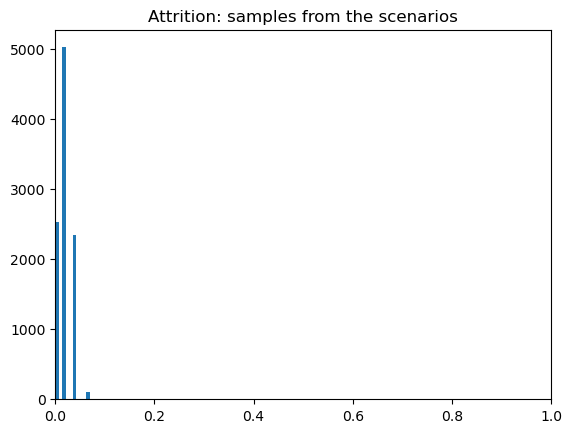

In [9]:
# fit the beta
n_samples = 10000
dist = scenarios["attrition"]
data = np.random.choice(dist["value"], n_samples, p=dist["probability"])
a, b, loc, scale = scipy.stats.beta.fit(data)

# check samples from the fitted beta
beta_samples = scipy.stats.beta(a=a, b=b, loc=0, scale=scale).rvs(1000)
plt.figure()
plt.hist(beta_samples)
plt.xlim(0,1)
plt.title(f"Attrition: Beta distribution fitted to scenarios")
plt.figure()
plt.hist(data);
plt.title("Attrition: samples from the scenarios")
plt.xlim(0,1)

On further reflection, for mathematical convenience when modelling the loss, it might be helpful to approximate attrition as a lognormal. We can then sample from a multivariate normal distribution later.

**New assumptions**
* The attrition rate can be approximated as a lognormal

Text(0.5, 1.0, 'Attrition: samples from scenario table')

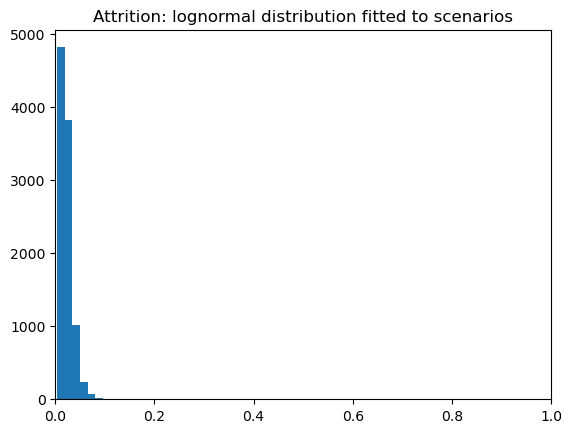

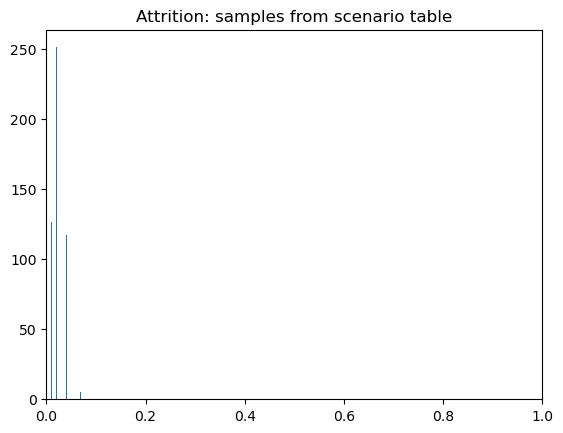

In [10]:
# fit attrition to a lognormal
# remove 0s from data to avoid inf errors
data = [0.01 if x == 0 else x for x in data]

# fit the log of the data to a normal distribution
log_data = [np.log(x) for x in data]
mu, std = scipy.stats.norm.fit(log_data, method="mle")

# lognormal parameters
attrition_s = std
loc = 0 # assume variable can take a 0 value, informed by scenarios
attrition_scale = np.exp(mu)
    
# plot the scenarios against a fitted lognormal
data_range = max(dist["value"])
x=np.linspace(0, 1)
lognormal_dist = scipy.stats.lognorm(s=attrition_s, loc=loc, scale=attrition_scale).rvs(10_000)
plt.figure()
plt.hist(lognormal_dist);
plt.xlim(0,1)
plt.title(f"Attrition: lognormal distribution fitted to scenarios")
plt.figure()
plt.hist(data, density=True, bins=30);
plt.xlim(0,1)
plt.title(f"Attrition: samples from scenario table")

This looks pretty good! And essentially zero chance of sampling a >1 value from the lognormal - so this seems like a decent approximation!

#### Fitting the other lognormals

The basic approach here is to fit samples from the scenario table to the normal distribution and then re-paramterise that Normal as a lognormal. We will then inspect the scenario data against the pdf of the fitted distribution as a sense check on the approach.

In [11]:
# assumptions for minimums for each variable
minimum_expected_values = {
    "downtime_minutes": 0,
    "revenue_per_minute": 25,
    "active_clients": 250,
    "revenue_per_client": 100
}

In [12]:
def fit_lognormal_distribution(scen):
    # sample from probability table
    dist = scenarios[scen]
    n_samples = 10000
    data = np.random.choice(dist["value"], n_samples, p=dist["probability"])

    # fit the log of the data to a normal distribution
    log_data = [np.log(x) for x in data]
    mu, std = scipy.stats.norm.fit(log_data, method="mle")

    # lognormal parameters
    s = std
    loc = 0
    loc = minimum_expected_values[scen]
    scale = np.exp(mu)
    
    # plot the scenarios against a fitted lognormal
    data_range = max(dist["value"])
    x=np.linspace(0, data_range, data_range)
    lognormal_dist = scipy.stats.lognorm.pdf(x, s=s, loc=loc, scale=scale)
    plt.figure()
    plt.plot(lognormal_dist)
    plt.hist(data, density=True, bins=30);
    plt.title(f"{scen}: lognormal distribution fitted to scenarios")
    
    # return the scipy lognormal parameters
    return s, loc, scale

{'downtime_minutes': (0.9951706136093015, 0, 25.02789647505564), 'revenue_per_minute': (0.8796459224922655, 25, 446.57428826228175), 'active_clients': (0.25735731593497074, 250, 1404.4063115047466), 'revenue_per_client': (0.5354854199889717, 100, 670.7773670621119)}


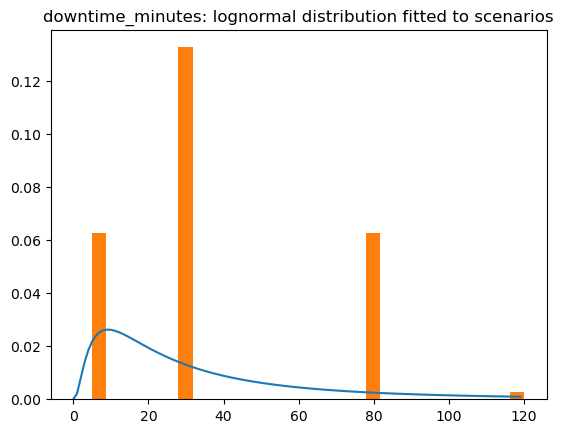

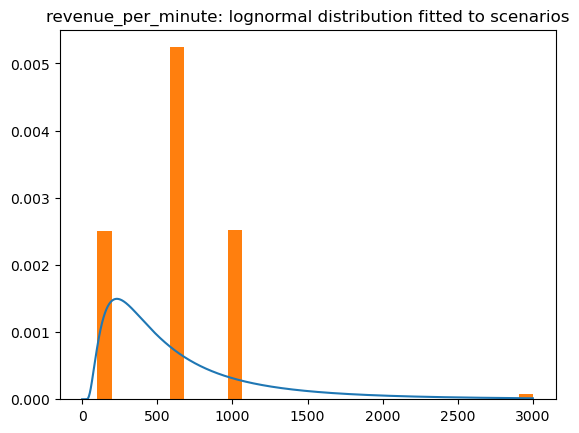

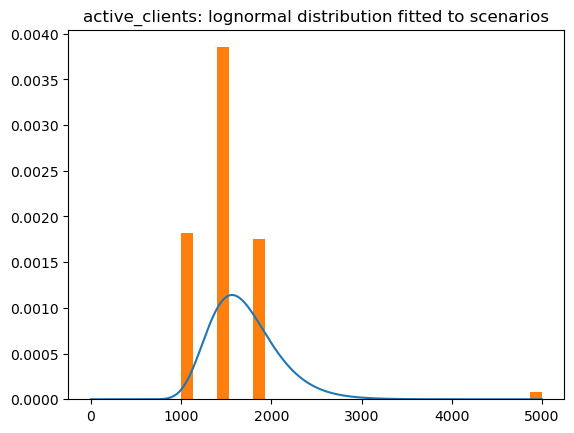

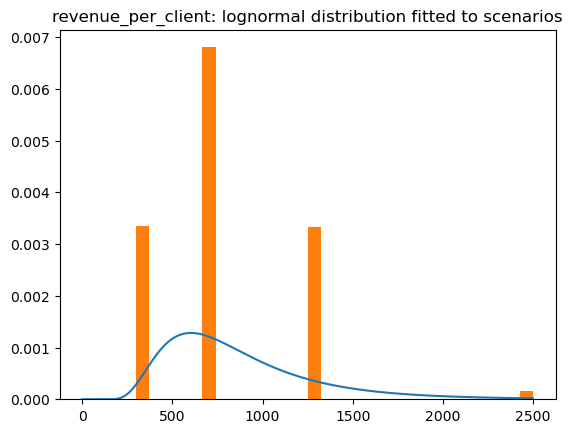

In [13]:
# loop through the variables we want to fit as lognormal and append the fitted parameters to a dictionary
params = {}

for scen in ["downtime_minutes", "revenue_per_minute", "active_clients", "revenue_per_client"]:
    params[scen] = fit_lognormal_distribution(scen)

print(params)

In [14]:
# append the attrition parameters
params["attrition"] = (attrition_s, 0, attrition_scale)
params

{'downtime_minutes': (0.9951706136093015, 0, 25.02789647505564),
 'revenue_per_minute': (0.8796459224922655, 25, 446.57428826228175),
 'active_clients': (0.25735731593497074, 250, 1404.4063115047466),
 'revenue_per_client': (0.5354854199889717, 100, 670.7773670621119),
 'attrition': (0.5001455553512667, 0, 0.01999744599470697)}

In [15]:
# check the probability of the "extreme" scenarios under our assumed distributions
for scen in scenarios:
    prob_extreme = scipy.stats.lognorm(*params[scen]).cdf(scenarios[scen]["value"][3])
    print(f"For {scen}, assumed likelihood of extreme scenario is {np.round(1-prob_extreme, 3)}")

For downtime_minutes, assumed likelihood of extreme scenario is 0.058
For revenue_per_minute, assumed likelihood of extreme scenario is 0.016
For active_clients, assumed likelihood of extreme scenario is 0.0
For attrition, assumed likelihood of extreme scenario is 0.006
For revenue_per_client, assumed likelihood of extreme scenario is 0.009


These look broadly reasonable - we do not expect these to perfectly align with the scenario samples - they are just being used as a guide. However, the "extreme" scenario for active clients has a zero probability in our fitted lognormal - which is a concern!

It's possible that lognormal is less appropriate for modelling the number of clients, especially given active clients is technically discrete, as we mentioned earlier. Perhaps we can make a manual adjustment to the fitted lognormal to improve this.

##### a) Manual adjustment to the active_clients distribution

Increase the "s" and "loc" parameters to get to a higher chance of there being 5_000 active clients.

(0.0, 5000.0)

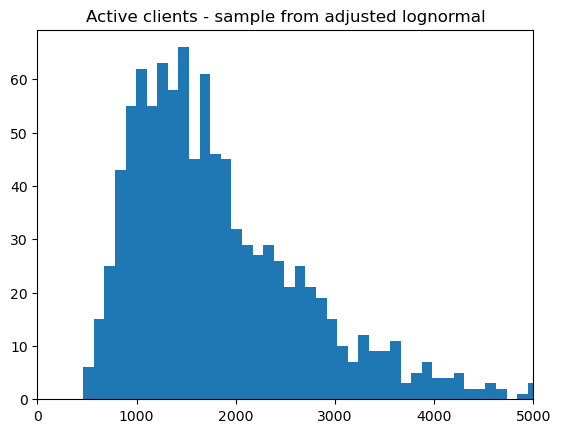

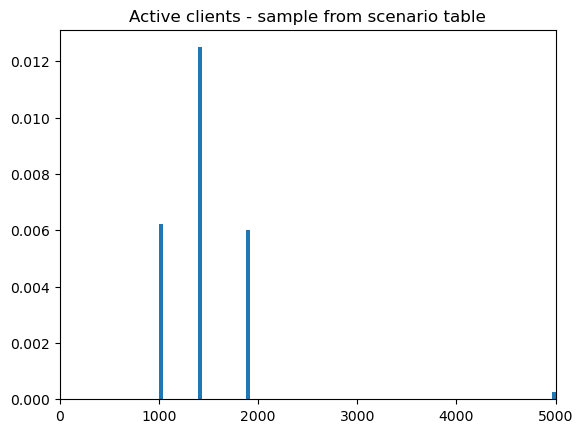

In [16]:
# revisit the "active_clients" distribution and manually fit it
ps = (0.6, 250, 1396.6664016422883) # bump up s from 0.3ish to 0.6 and assume min no. of active clients of 250
dist = scenarios["active_clients"]
active_clients_logn = scipy.stats.lognorm(*ps)
n_samples = 100000
data = np.random.choice(dist["value"], n_samples, p=dist["probability"])
plt.figure()
plt.hist(active_clients_logn.rvs(1000), bins=100)
plt.title("Active clients - sample from adjusted lognormal")
plt.xlim(0,5_000)
plt.figure()
plt.hist(data, density=True, bins=100);
plt.title("Active clients - sample from scenario table")
plt.xlim(0,5_000)

In [17]:
# check the likelihood of hitting each scenario
print("Extreme: ",active_clients_logn.cdf(scenarios["active_clients"]["value"][3]))
print("High: ",active_clients_logn.cdf(scenarios["active_clients"]["value"][2]))
print("Medium: ",active_clients_logn.cdf(scenarios["active_clients"]["value"][1]))
print("Low: ",active_clients_logn.cdf(scenarios["active_clients"]["value"][0]))

Extreme:  0.9793295147844063
High:  0.6094215532838333
Medium:  0.37301550740821277
Low:  0.15003486216578982


In [18]:
# reassign the parameters
params["active_clients"] = ps

### Defining the correlations

**Assumptions about correlations between variables**
* Both revenue variables are independent of all other variables
* Downtime is strongly postively correlated with the number of active users. Assume correlation coefficient of 0.7.
* Downtime is less strongly positively correlated with attrition. Assume correlation coefficient of 0.5.

In [19]:
# assumptions for correlations
r_dt_au = 0.7 # downtime is strongly correlated with the no. of active users
r_dt_att = 0.5 # downtime is less strongly correlated with the rate of attrition

### Monte Carlo

#### a) Define distributions to sample from

* Define a multi-variate normal for downtime, active_clients and attrition. We will then exponentiate the samples from this distribution to the "lognormal" values during the MC simulation.
* We will just use the previously fitted lognormals for the revenue variables.

In [20]:
# define MV normal
means = [params["downtime_minutes"][2],
         params["active_clients"][2],
         params["attrition"][2]]
means = [np.log(x) for x in means]

stds = [params["downtime_minutes"][0],
        params["active_clients"][0],
        params["attrition"][0]]

cov = [
    [stds[0]**2, stds[0]*stds[1]*r_dt_au, stds[0]*stds[2]*r_dt_att],
    [stds[0]*stds[1]*r_dt_au, stds[1]**2, 0],
    [stds[0]*stds[2]*r_dt_att, 0, stds[2]**2]
]

mvn = scipy.stats.multivariate_normal(mean=means, cov=cov)

In [21]:
# define remaining lognormals
rev_per_min_logn = scipy.stats.lognorm(*params["revenue_per_minute"])
rev_per_client_logn = scipy.stats.lognorm(*params["revenue_per_client"])

#### b) Run simulation

In [22]:
def get_sample_loss(seed):
    """
    Calculate loss for a single sample
    """
    downtime, active_clients, attrition = mvn.rvs(1, random_state=seed)
    revenue_per_minute = rev_per_min_logn.rvs(1, random_state=seed)
    revenue_per_client = rev_per_client_logn.rvs(1, random_state=seed)
    direct_loss = np.exp(downtime) * revenue_per_minute
    indirect_loss = np.exp(active_clients) * np.exp(attrition) * revenue_per_client
    loss = direct_loss + indirect_loss
    return direct_loss, indirect_loss, loss

# loop through samples and calculate distribution of losses
losses = []
direct_losses = []
indirect_losses = []
n_samples = 100_000
for n in tqdm(range(n_samples)):
    direct_loss, indirect_loss, loss = get_sample_loss(seed=n)
    losses.append(loss[0])
    direct_losses.append(direct_loss[0])
    indirect_losses.append(indirect_loss[0])

100%|██████████| 100000/100000 [01:33<00:00, 1066.77it/s]


(0.0, 300000.0)

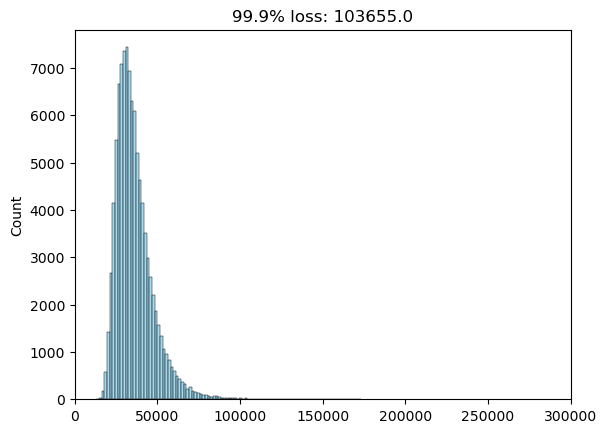

In [23]:
# plot the distribution of losses
ax = sns.histplot(losses,
                  bins=100,
                  color='skyblue')
ax.set_title(f"99.9% loss: {round(np.percentile(losses, 99.9),0)}")
plt.xlim(0, 300_000)

(0.0, 300000.0)

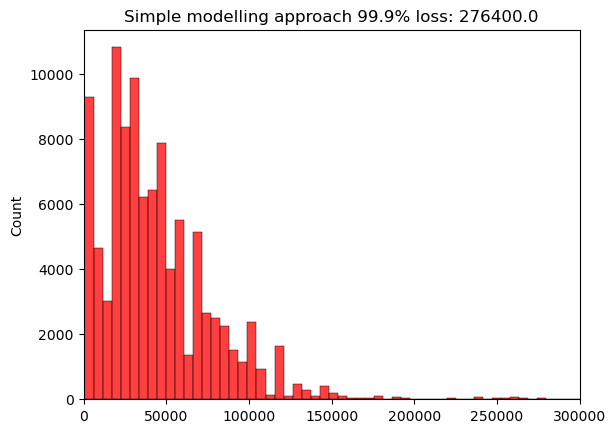

In [24]:
# re-plot the distribution of losses for the simple approach
ax = sns.histplot(losses_simple,
                  bins=100,
                  color='red')
ax.set_title(f"Simple modelling approach 99.9% loss: {round(np.percentile(losses_simple, 99.9),0)}")
plt.xlim(0, 300_000)

## Discussion of results

* The MC simulation is stable at 100,000 samples (after noting minimal difference in results after running on a variety of seeds). It's also quick to run.
* The 1 in 1000 financial loss due to system downtime is c.105,000.
* It's interesting to note that, in comparison, the simple method of sampling from the scenario table returns a 1 in 1000 loss of c.275,000.
* My prior expectation was that the addition of correlations would mean a higher loss under the second method, as these positive links between downtime and attrition / active clients would amplify the loss in the extreme scenarios. 
* The reason for the difference is more that the fitted lognormals significantly underestimate the likelihood of the "high" scenario values compared with the scenario tables. The scenario tables just aren't consistent with the lognormal distribution. However, prior knowledge about the phenomena being modelled do suggest that the lognormal should be appropriate, especially for revenue and downtime. We could try substituting for a gamma assumption, although I do not expect this to make a material difference.
* Another method that could be tried in future is to continue with sampling from the scenario table, but to build in correlations.
* Another possible future line of work could be to revisit the approach to fitting our Normal distributions - fitting directly to the scenario data might not be the best approach - we could perhaps first have made some manual adjustments to the scenario tables by "filling in the gaps", before attempting to fit the data.

* Overall, an extremely enjoyable technical test - I have learned a lot, and it has made me even more excited about this role!